In [518]:
#import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#display options
from IPython.display import display
pd.options.display.float_format = '{:.2f}'.format

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 1.8)

import warnings
#warnings.SettingWithCopyWarning
pd.options.mode.chained_assignment = None

#read the collected 
df_init = pd.read_csv('final_movie_data.csv',index_col=0)

df = df_init.copy()
df.head(2)

,title,budget,revenue,genres,production_countries,production_companies,adult,popularity,original_language,release_date,runtime,vote_average,vote_count
0,Independence Day,75000000,817400891,"Action, Adventure, Science Fiction",United States of America,"Centropolis Entertainment, 20th Century Fox",False,17.07,en,1996-06-25,145.00,6.80,5595
1,The Matrix,63000000,463517383,"Action, Science Fiction","Australia, United States of America","Village Roadshow Pictures, Groucho II Film Par...",False,35.72,en,1999-03-30,136.00,8.10,14757


In [519]:
#####preprocessing#####

#fill missing values for run time with median
df.runtime.fillna(df_init.runtime.median(),inplace=True)

#fill mising values with 'missing'
df.genres.fillna('missing',inplace=True)
df.production_countries.fillna('missing',inplace=True)
df.production_companies.fillna('missing',inplace=True)

#rescale bugdet to list in million $
scale = 10**6
df['budget_M'] = df['budget'].div(scale)
df['revenue_M'] = df['revenue'].div(scale)

#total budget in million $ and %
df['return_M'] = df.revenue_M - df.budget_M
df['return_%'] = round(df.return_M/df.budget_M * 100, 2)

#add positive/negative return %
df['return_%_type'] = df['return_%'].map(lambda x: 'positive'
                                       if x > 0 else 'negative')

#add year column
df.release_date = df.release_date.astype('datetime64[ns]')
df['year'] = df.release_date.dt.year.fillna(0).astype('int64')

#add first genre column
df['first_genre'] = [x.split(', ')[0] if x is not np.nan 
                                           else np.nan for x in df.genres]
#add first company column
df['first_company'] = [x.split(', ')[0] if x is not np.nan 
                                             else np.nan for x in df.production_companies]
#add first country column
df['first_country'] = [x.split(', ')[0] if x is not np.nan 
                                             else np.nan for x in df.production_countries]

#select necessary columns
df = df[['title','year','first_genre','first_country','first_company',
         'budget_M','revenue_M','return_M','return_%','return_%_type','runtime']]   


df.head()

,title,year,first_genre,first_country,first_company,budget_M,revenue_M,return_M,return_%,return_%_type,runtime
0,Independence Day,1996,Action,United States of America,Centropolis Entertainment,75.00,817.40,742.40,989.87,positive,145.00
1,The Matrix,1999,Action,Australia,Village Roadshow Pictures,63.00,463.52,400.52,635.74,positive,136.00
2,The Matrix Reloaded,2003,Adventure,Australia,Heineken Branded Entertainment,150.00,738.60,588.60,392.40,positive,138.00
3,The Matrix Revolutions,2003,Adventure,United States of America,Silver Pictures,150.00,424.99,274.99,183.33,positive,129.00
4,Out of Africa,1985,History,United States of America,Universal Pictures,31.00,128.50,97.50,314.51,positive,161.00


In [520]:
df.describe()

,year,budget_M,revenue_M,return_M,return_%,runtime
count,5390.00,5390.00,5390.00,5390.00,5390.00,5390.00
mean,1957.98,26.34,72.50,46.16,1038238.75,108.59
std,292.13,62.94,155.62,138.33,57601744.31,37.54
min,0.00,0.00,-0.00,-3499.05,-200.00,1.00
25%,1995.00,2.00,1.89,-0.38,-17.98,94.00
50%,2006.00,10.50,16.16,3.66,95.08,105.00
75%,2012.00,30.00,71.28,40.59,303.83,121.00
max,2020.00,3500.05,2787.97,2550.97,4166449900.00,2000.00


In [521]:
df.describe(include=['object'])

,title,first_genre,first_country,first_company,return_%_type
count,5390,5390,5390,5390,5390
unique,5312,20,82,2322,2
top,The Three Musketeers,Drama,United States of America,missing,positive
freq,3,1305,2975,450,3654


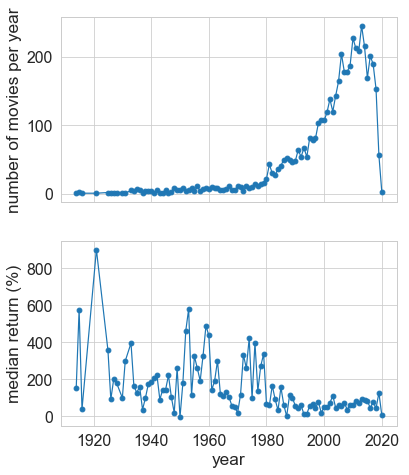

In [522]:
#What is distribution of movies by a year?
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,7),sharex=True)

#filter missing years and return greater than 1000%
filter_cond = (df.year > 0) & (df['return_%'] < 1000)

##subplot 1
#numbers of movies over time in the database
df[filter_cond].year.value_counts().sort_index()\
               .plot(kind='line',ax=ax1,marker='o')

#change axis labels
ax1.set_xlabel('year')
ax1.set_ylabel('number of movies per year')

##subplot 2
#Median return in % versus release year
df[filter_cond].groupby('year')['return_%'].median()\
               .plot(kind='line',ax=ax2,marker='o')

#change axis labels
ax2.set_xlabel('year')
ax2.set_ylabel('median return (%)')

#change axis limits
#ax2.set_ylim(0,150)
#ax2.set_xlim(1987,2018)

## zoom 

plt.tight_layout()

28.9% of movies have negative return.


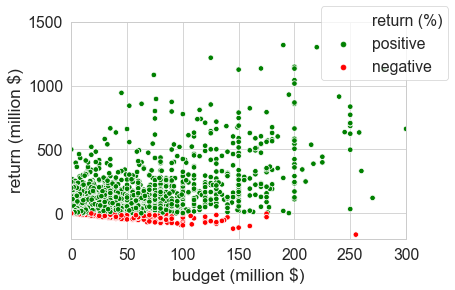

In [523]:
#How budget influence on total revenue in millions?
fig, ax1 = plt.subplots(1,1,figsize=(6,4))

#plot return vs budget in millions $
sns.scatterplot(x='budget_M', y='return_M', hue='return_%_type',
                data=df, s=30, ax=ax1,palette=['green','red'])

#change axis labels
ax1.set_xlabel('budget (million $)')
ax1.set_ylabel('return (million $)')

#legend parameters
ax1.legend(loc='right',bbox_to_anchor = [1.15, 0.9])\
   .texts[0].set_text("return (%)")

#change axis limits
ax1.set_xlim(0,300)
ax1.set_ylim(-200,1500)

#What is the percentage of movies with negative revenue?
neg_return = round(df[df.return_M < 0].shape[0] 
                   / df.shape[0] * 100,1)
print(f'{neg_return}% of movies have negative return.')

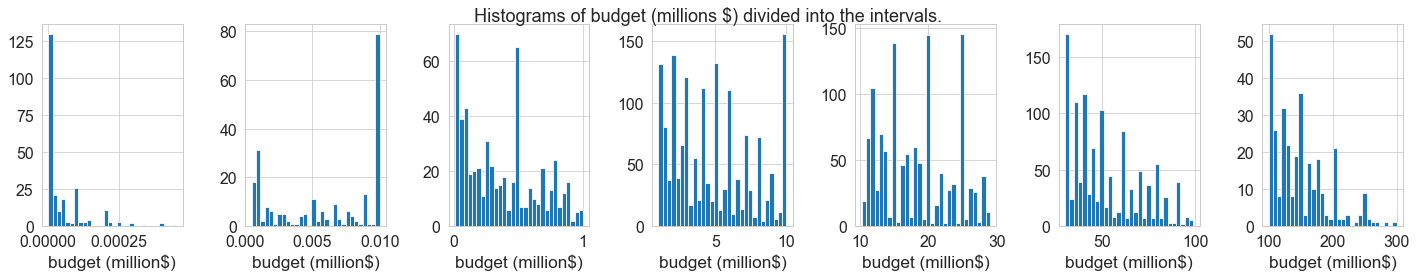

In [524]:
#What is distribution of movies by a budget?
#How to categorize the budget?
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7,figsize=(20,4))

df[df.budget_M < 0.0005].budget_M.hist(bins=30,ax=ax1) #under 0.5k
ax1.set_xlabel('budget (million$)')

df[(df.budget_M >= 0.0005) & (df.budget_M <= 0.01)].budget_M.hist(bins=30,ax=ax2) #between 0.5k and 10k
ax2.set_xlabel('budget (million$)')

df[(df.budget_M > 0.01) & (df.budget_M < 1)].budget_M.hist(bins=30,ax=ax3) #between 10k and 1M
ax3.set_xlabel('budget (million$)')

df[(df.budget_M >= 1) & (df.budget_M <= 10)].budget_M.hist(bins=30,ax=ax4) #between 1M and 10M
ax4.set_xlabel('budget (million$)')

df[(df.budget_M > 10) & (df.budget_M < 30)].budget_M.hist(bins=30,ax=ax5) #between 10M and 30M
ax5.set_xlabel('budget (million$)')

df[(df.budget_M >= 30) & (df.budget_M < 100)].budget_M.hist(bins=30,ax=ax6) #between 30M and 100M
ax6.set_xlabel('budget (million$)')

df[(df.budget_M >= 100) & (df.budget_M <= 300)].budget_M.hist(bins=30,ax=ax7) #over 100M
ax7.set_xlabel('budget (million$)')

#add common title
plt.suptitle('Histograms of budget (millions $) divided into the intervals.',fontsize=18)
plt.tight_layout()

In [525]:
#add a new column with budget categories
df['budget_category'] = pd.cut(df.budget_M,[0,0.0005,0.01,1,10,30,100,1000],
                               labels=['< 0.5k','[0.5k, 10k]',
                                       '(10k, 1M)',
                                       '[1M, 10M]',
                                       '(10M, 30M)',
                                       '[30M, 100M)',
                                       '>= 100M'
                                      ])

,Q1,Q2 (median),Q3
budget,,,
< 0.5k,-21.66,0.00,92.83
"[0.5k, 10k]",0.00,50.00,317.18
"(10k, 1M)",-1.79,100.00,326.87
"[1M, 10M]",-56.62,63.85,242.56
"(10M, 30M)",-41.15,52.45,223.75
"[30M, 100M)",-9.01,80.67,206.28
>= 100M,86.17,175.59,318.03


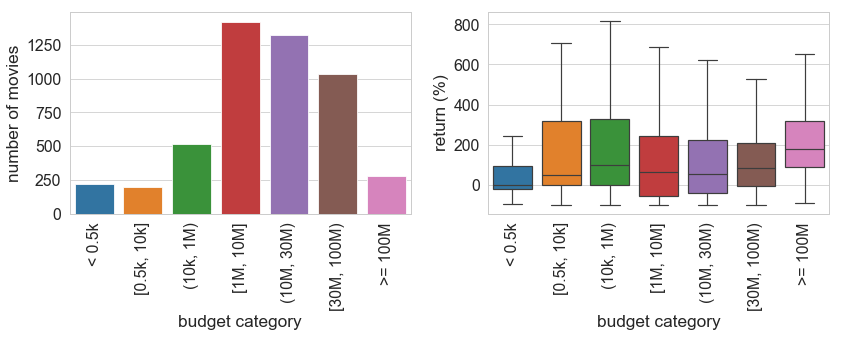

In [561]:
#return vs budget category: how much money to invest?
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

#filter the outliers in terms of return
filter_cond = (df['return_%'] < 1000) #& (df['budget_M'] >= 0.0005)

#plot the number of movies versus budget category
sns.countplot(x='budget_category', data=df[filter_cond], ax=ax1)
#change axis labels
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
ax1.set_xlabel('budget category')
ax1.set_ylabel('number of movies')

#plot return in % versus budget category
sns.boxplot(x='budget_category',y='return_%',data=df[filter_cond],showfliers=False,ax=ax2)
#change axis labels
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
ax2.set_xlabel('budget category')
ax2.set_ylabel('return (%)')

plt.tight_layout()


#add table with median and 25,75 percentiles
def perc_25(x):
    return np.percentile(x, q = [25])
def perc_75(x):
    return np.percentile(x, q = [75])

d = df[filter_cond].groupby('budget_category')['return_%']\
                   .agg([perc_25,np.median,perc_75])
d.index.names = ['budget']
d.rename(columns={'perc_25':'Q1','median':'Q2 (median)','perc_75':'Q3'},inplace=True)
display(d)

In [562]:
#analysis of categorical columns

#function to select top most frequent categories
def quick_cat(_series,top_number):
    #count values in a column and normalize to show percentage
    top = _series.value_counts(normalize=True)[:top_number]    
    
    print(f"Number of unique values is {_series.nunique()}.")
    print(f"The first {top_number} items are present in {round(top.sum()*100,1)} % of data.")
    
    return top

#select top most frequent genres
select_genre = quick_cat(df.first_genre,top_number=6).index
df['select_genre'] = df['first_genre'].map(lambda x: x if x in select_genre else 'other')

#define hue_order to compare different plots
hueorder = list(select_genre).append('other')

#select top most frequent countries
select_country = list(quick_cat(df.first_country,top_number=6).index)
select_country.remove('missing')
df['select_country'] = df['first_country'].map(lambda x: x if x in select_country else 'other')

#select top most frequent companies
select_company = list(quick_cat(df.first_company,top_number=21).index)
select_company.remove('missing')
df['select_company'] = df['first_company'].map(lambda x: x if x in select_company else 'other')

Number of unique values is 20.
The first 6 items are present in 78.1 % of data.
Number of unique values is 82.
The first 6 items are present in 80.5 % of data.
Number of unique values is 2322.
The first 21 items are present in 29.9 % of data.


budget_category,< 0.5k,"[0.5k, 10k]","(10k, 1M)","[1M, 10M]","(10M, 30M)","[30M, 100M)",>= 100M
select_genre,,,,,,,
Action,18,41,42,216,202,247,102
Adventure,5,2,12,48,78,104,78
Comedy,34,32,97,314,299,206,5
Crime,3,2,25,82,76,57,1
Drama,29,51,169,401,364,176,14
Horror,15,7,34,103,79,35,2
other,118,65,139,259,226,211,75


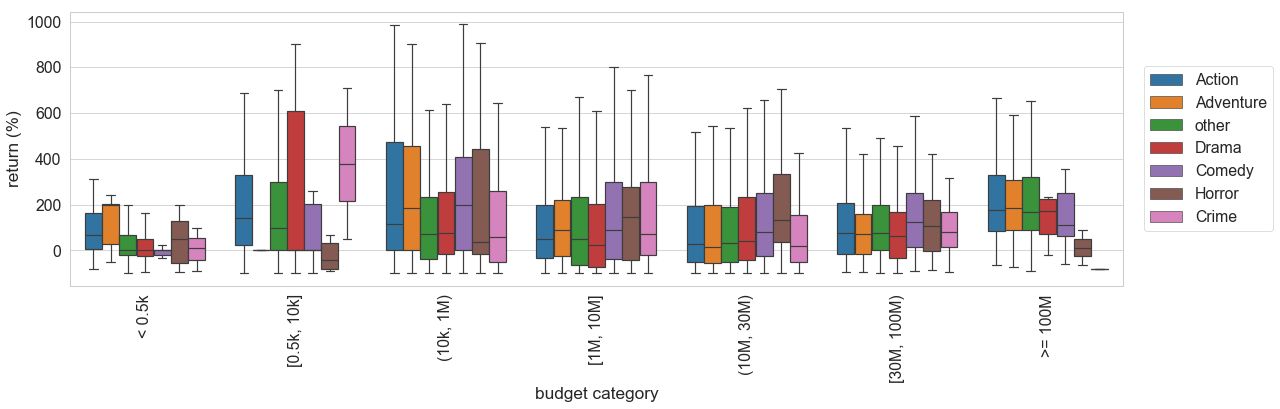

In [563]:
#How genre influence the return in different budget categories?
fig, ax = plt.subplots(1,1,figsize=(18,6))

#plot return in % versus budget category for most common genres
ax = sns.boxplot(x='budget_category',y='return_%',hue='select_genre',
            data=df[filter_cond],showfliers=False)

#change legend location
ax.legend(loc='right',bbox_to_anchor = [1.15, 0.5])
#change axis labels
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_xlabel('budget category')
ax.set_ylabel('return (%)')

plt.tight_layout()

#add table showing numbers of movies in a given budget category and genre
df[filter_cond].groupby(['select_genre','budget_category'])\
                        ['budget_category'].count().unstack().fillna(0).astype('int64')

budget,< 0.5k,"[0.5k, 10k]","(10k, 1M)","[1M, 10M]","(10M, 30M)","[30M, 100M)",>= 100M
,,,,,,,
Canada,3,3,6,51,64,45,10
France,1,0,6,52,60,42,3
India,13,5,113,197,31,5,1
United Kingdom,11,4,16,94,95,58,31
United States of America,51,52,175,686,860,725,187
other,143,136,202,343,214,161,45


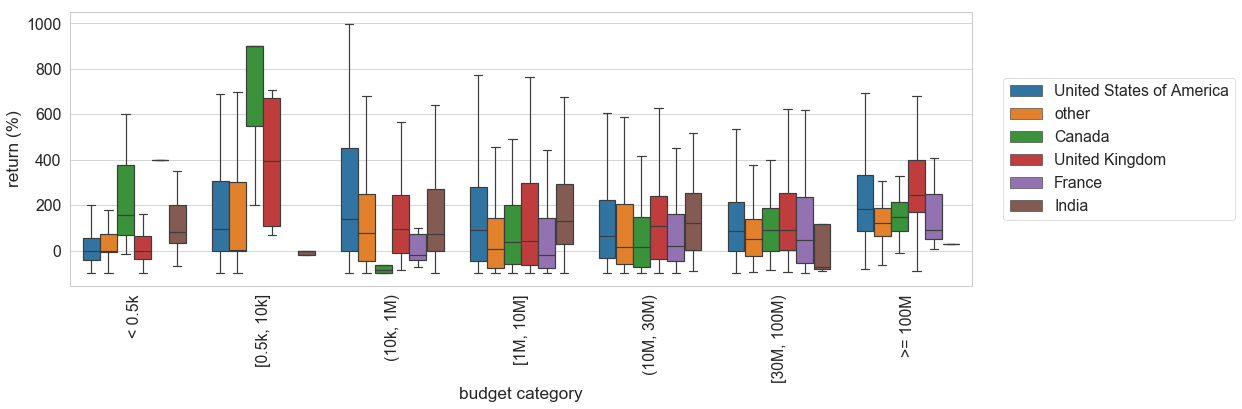

In [564]:
#How country influence the return in different budget categories?
fig, ax = plt.subplots(1,1,figsize=(18,6))

#plot return in % versus budget category for most common countries
ax = sns.boxplot(x='budget_category',y='return_%',hue='select_country',
            data=df[filter_cond],showfliers=False)
#change legend location
ax.legend(loc='right',bbox_to_anchor = [1.3, 0.5])
#change axis labels
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_xlabel('budget category')
ax.set_ylabel('return (%)')

plt.tight_layout()

#add table showing numbers of movies in a given budget category and country
df_count = df[filter_cond].groupby(['select_country','budget_category'])\
                                   ['budget_category'].count().unstack()\
                                                      .fillna(0).astype('int64')
#rename index names
df_count.index.names = ['']
df_count.columns.names = ['budget']

df_count

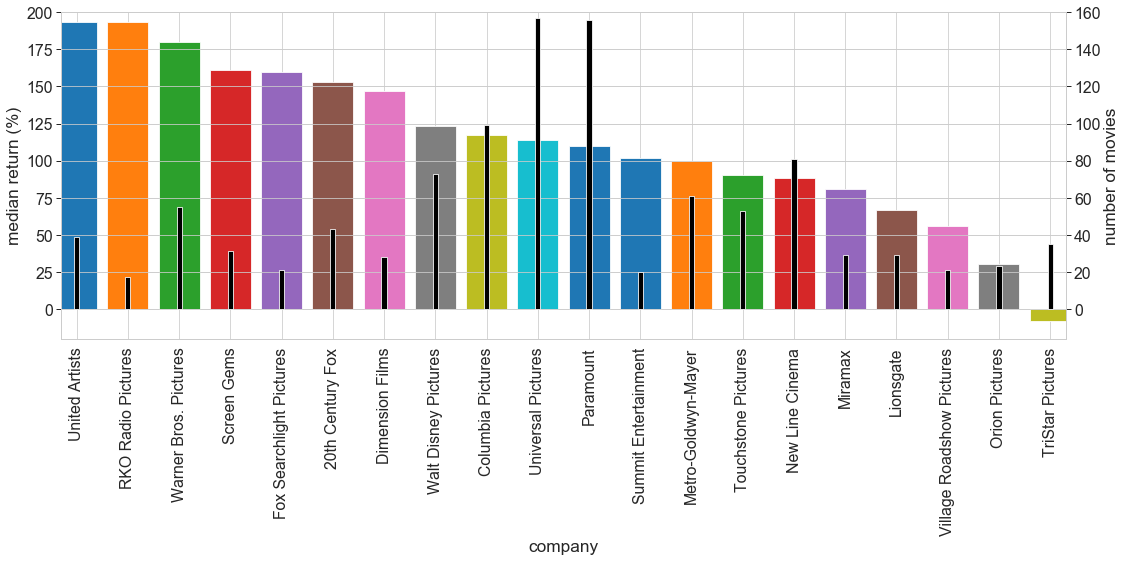

In [565]:
#How company influence the return in different budget categories?
fig, ax1 = plt.subplots(1,1,figsize=(18,6))

filter_other = (df.select_company != 'other') 

#plot return in % versus budget category for different companies
#select a group
group = df[filter_cond & filter_other]\
                       .groupby('select_company')['return_%']\
                       .agg(['median','count'])\
                       .sort_values(by='median',ascending=False)
#plot
group['median'].plot(kind='bar',ax=ax1,width=0.8)#pos

#change axis labels
ax1.set_ylabel('median return (%)')
ax1.set_xlabel('company')
ax1.set_ylim(-20,200)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
group['count'].plot(kind='bar',ax=ax2,color='k',width=0.1)
ax2.set_ylabel('number of movies')
_ = ax2.set_ylim(-16,160)

In [566]:
def plot_return_filter(filter_add,hue_by,hue_order,_xlim,_title):
    fig, ax = plt.subplots(1,1,figsize=(18,6))

    #plot return in % versus budget category for most common genres
    ax = sns.boxplot(x='budget_category',y='return_%',hue=hue_by,
                     hue_order = hue_order,
                     data=df[filter_cond & filter_add],showfliers=True)

    #change legend location
    ax.legend(loc='right',bbox_to_anchor = [1.15, 0.5])
    #change axis labels
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.set_xlabel('budget category')
    ax.set_ylabel('return (%)')
    ax.set_xlim(_xlim)
    ax.set_title(_title)

    plt.tight_layout()

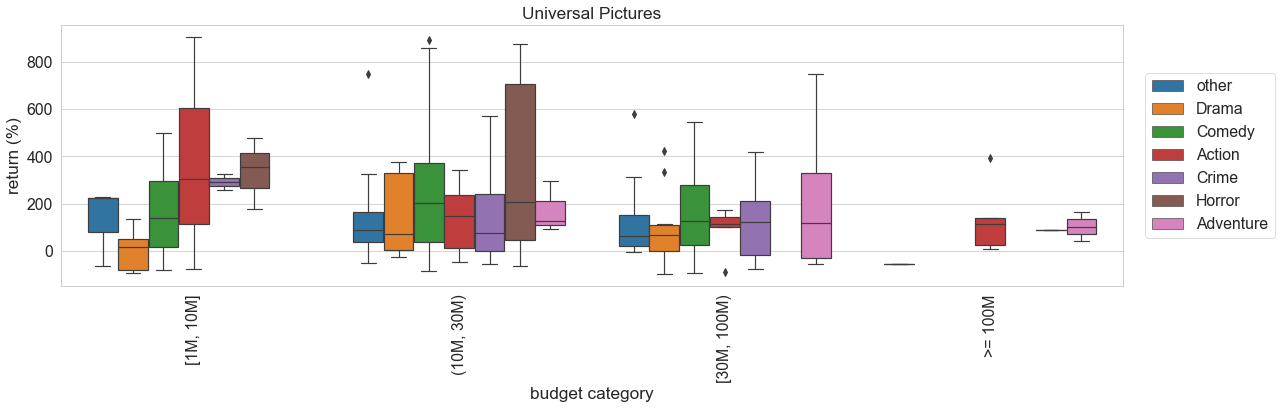

In [567]:
# return vs budget for most common genres
company = 'Universal Pictures' 
filter_UP = (df.first_company == company)
plot_return_filter(filter_add = filter_UP,
                   hue_by = 'select_genre',
                   hue_order = hueorder,
                   _xlim = (2.5,6.5),
                   _title = company)

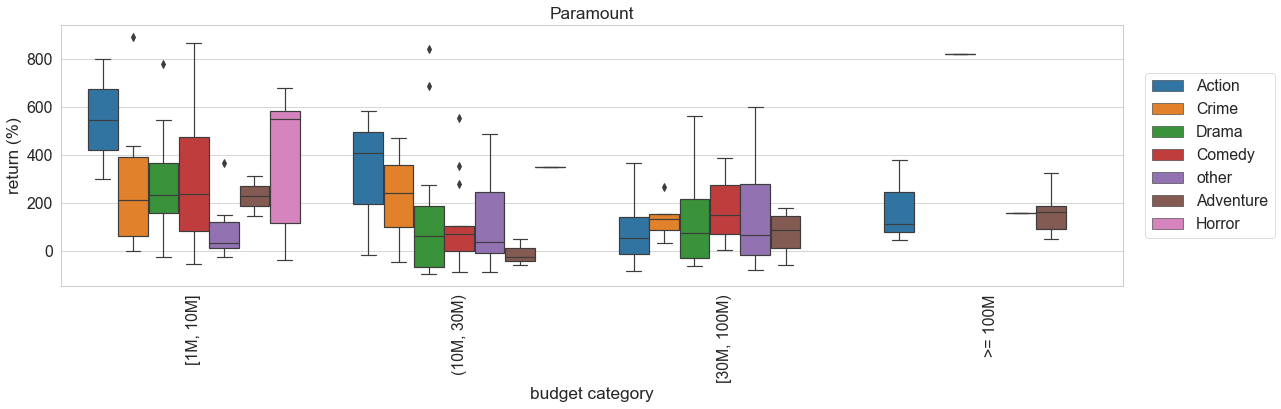

In [568]:
#return vs budget for most common genres
company = 'Paramount' 
filter_UP = (df.first_company == company)
plot_return_filter(filter_add = filter_UP,
                   hue_by = 'select_genre',
                   hue_order = hueorder,
                   _xlim = (2.5,6.5),
                   _title = company)

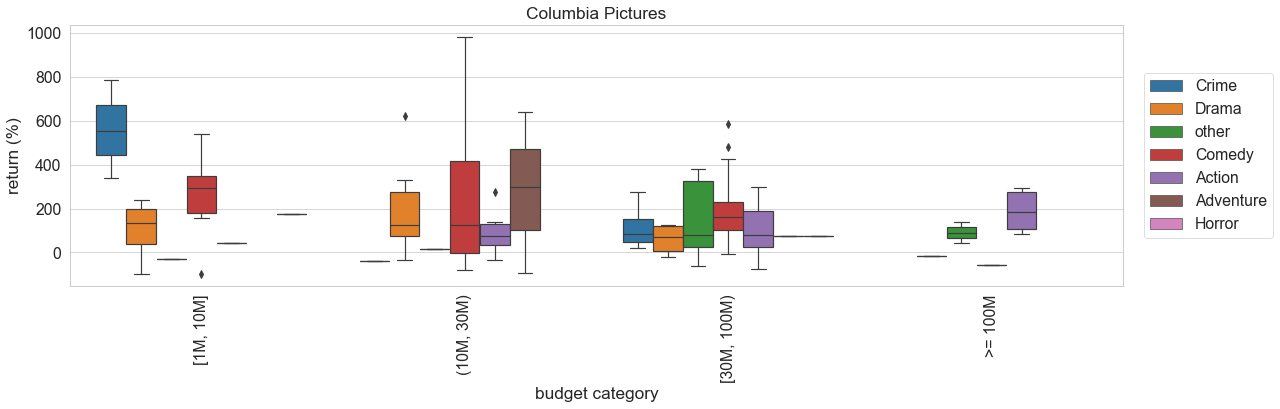

In [569]:
#return vs budget for most common genres
company = 'Columbia Pictures'
filter_UP = (df.first_company == company)
plot_return_filter(filter_add = filter_UP,
                   hue_by = 'select_genre',
                   hue_order = hueorder,
                   _xlim = (2.5,6.5),
                   _title =company)

### Questions to answer: How much money to invest? In what company? In what genre? 
 * For (1M,30M) budget choose Paramount company to film Action movies

Need to optimize return (%) (large median), minimaze risk (low std) for a given budget category.

In [570]:
#Having sufficient data, optimize return (large median) and minimaze risk (low std) 
#First select budget range than company and after that genre
df[filter_cond & filter_other].groupby(['budget_category'
                                        ,'select_company'
                                        ,'select_genre'])['return_%']\
                              .agg(['count','median','std'])\
                              .sort_values(by='std',axis=0,ascending=True)\
                              .sort_values(by=['count','median'],axis=0,ascending=False).head(10)

count  median    std
budget_category select_company     select_genre                      
(10M, 30M)      Universal Pictures Comedy           16  205.11 323.81
[30M, 100M)     Paramount          Action           16   52.67 123.10
                Columbia Pictures  Comedy           14  160.84 176.41
                Universal Pictures Comedy           14  128.46 178.44
(10M, 30M)      New Line Cinema    Comedy           14   96.46 170.50
                Paramount          Comedy           14   69.95 176.38
                                   Drama            14   62.39 288.80
[1M, 10M]       Universal Pictures Comedy           13  138.38 186.03
[30M, 100M)     Columbia Pictures  Action           13   81.17 123.65
(10M, 30M)      Universal Pictures Drama            13   74.61 160.82

In [571]:
#What happens if first optimize return (large median) and minimaze risk (low std) 
#First select budget range than company and after that genre
df[filter_cond & filter_other].groupby(['budget_category'
                                        ,'first_company'
                                        ,'select_genre'])['return_%']\
                              .agg(['count','median','std'])\
                              .sort_values(by='std',axis=0,ascending=True)\
                              .sort_values(by=['median'],axis=0,ascending=False).head(10)

count  median    std
budget_category first_company         select_genre                      
>= 100M         Warner Bros. Pictures other             1  973.60    nan
(10k, 1M)       Universal Pictures    Horror            2  882.51  31.47
(10M, 30M)      Metro-Goldwyn-Mayer   Adventure         1  879.33    nan
(10k, 1M)       Columbia Pictures     Action            1  827.69    nan
>= 100M         Paramount             Drama             1  822.52    nan
[1M, 10M]       United Artists        Comedy            4  767.07 206.08
                Warner Bros. Pictures other             1  759.46    nan
[30M, 100M)     Warner Bros. Pictures Adventure         1  738.35    nan
[1M, 10M]       Orion Pictures        Action            1  676.93    nan
(10k, 1M)       Warner Bros. Pictures Comedy            1  639.03    nan

In [572]:
df.loc[(df.budget_category=='>= 100M')&
       (df.first_company=='Warner Bros. Pictures'),
       ['title','year','first_genre','first_company','budget_category','return_%']]

,title,year,first_genre,first_company,budget_category,return_%
65,Harry Potter and the Philosopher's Stone,2001,Adventure,Warner Bros. Pictures,>= 100M,681.18
69,Harry Potter and the Order of the Phoenix,2007,Adventure,Warner Bros. Pictures,>= 100M,525.48
127,Harry Potter and the Half-Blood Prince,2009,Adventure,Warner Bros. Pictures,>= 100M,273.58
134,The Hobbit: An Unexpected Journey,2012,Adventure,Warner Bros. Pictures,>= 100M,308.44
842,The Hobbit: The Desolation of Smaug,2013,Adventure,Warner Bros. Pictures,>= 100M,283.36
826,Harry Potter and the Deathly Hallows: Part 1,2010,Adventure,Warner Bros. Pictures,>= 100M,281.72
827,Harry Potter and the Deathly Hallows: Part 2,2011,Family,Warner Bros. Pictures,>= 100M,973.60
783,The Hobbit: The Battle of the Five Armies,2014,Action,Warner Bros. Pictures,>= 100M,282.41


,Q1,Q2 (median),Q3
budget,,,
< 0.5k,1271.80,1271.80,1271.80
"[0.5k, 10k]",1900.00,5957.40,15733.33
"(10k, 1M)",1642.98,2885.07,9900.00
"[1M, 10M]",1293.71,1928.00,2955.71
"(10M, 30M)",1186.13,1466.86,2150.25
"[30M, 100M)",1186.04,1340.07,1609.97
>= 100M,1076.36,1076.36,1076.36


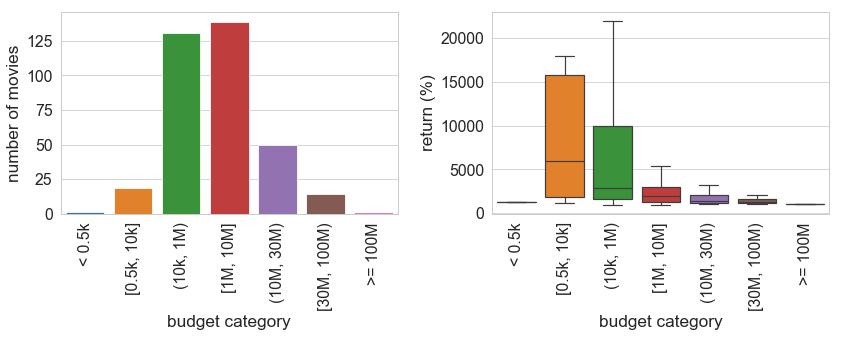

In [590]:
#analyze the filtered data
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

#filter low budget data as well
filter_cond = ~(df['return_%'] < 1000) & (df['budget_M'] >= 0.0005)

#plot the number of movies versus budget category
sns.countplot(x='budget_category', data=df[filter_cond], ax=ax1)
#change axis labels
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
ax1.set_xlabel('budget category')
ax1.set_ylabel('number of movies')

#plot return in % versus budget category
sns.boxplot(x='budget_category',y='return_%',data=df[filter_cond],showfliers=False,ax=ax2)
#change axis labels
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
ax2.set_xlabel('budget category')
ax2.set_ylabel('return (%)')

plt.tight_layout()

#summary
d = df[filter_cond].groupby('budget_category')['return_%']\
                   .agg([perc_25,np.median,perc_75])
d.index.names = ['budget']
d.rename(columns={'perc_25':'Q1','median':'Q2 (median)','perc_75':'Q3'},inplace=True)
display(d)

In [ ]:
#Future work: what is the best filtering?